Treinamento de modelo para prever o valor de um determinado imóvel com base nas suas características

## **Bibliotecas**

In [1]:
# Libs necessárias
import pandas as pd # trabalhar com dataframes
import numpy as np
from sklearn.model_selection import train_test_split # usado para separar os dados de treino e teste

# Avaliar quais features tem maior relevância para o modelo
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest

# Modelo Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Avaliação do Modelo
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from yellowbrick.regressor import PredictionError

# Libs gráficas
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.features import Rank2D # correlação

# Importação e Exportação de arquivos pkl
import joblib

# Avisos
import warnings
warnings.filterwarnings('ignore')

# Configuração no pandas
# simplificando a quantidade de linhas e colunas que o pandas vai mostrar sempre que quiser visualizar
pd.set_option('display.max_rows', 200)  
pd.set_option('display.max_columns', 100)

# Configuração no Matplotlib
plt.rcParams['figure.figsize'] = (15, 6) #ajustando o tamanho padrão do plot
plt.style.use('seaborn-darkgrid')        #ajustando o estilo padrão do plot

## **Exploração dos dados**

In [2]:
# Lendo os dados
base_dados = pd.read_csv('house_data.csv')

# Dimensão (linhas, colunas)
base_dados.shape

(10692, 13)

In [3]:
''' 
rooms = quartos / bathroom = banheiros / parking spaces = vagas de garagem / floor = andar / furniture = mobiliado
hoa = valor do condomínio / rent amount = valor do aluguel / property tax = valor do IPTU / fire insurance = valor do Suguro Incêndio 
'''
base_dados.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [4]:
# Removendo colunas que não são necessárias (inplace faz a alteração direto na base de dados)
base_dados.drop(columns=['fire insurance (R$)', 'total (R$)'], inplace=True)

In [5]:
# Verificando df sem as colunas
base_dados.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25


In [6]:
# Analisando se existe campos vazios

# "isnull()" verifica cada coluna se tem campo vazio
# "sum()" faz a contage de quantos campos vazios tem em cada coluna
# "sort_values(ascending=False)" ordena os valores do maior para o menor
base_dados.isnull().sum().sort_values( ascending=False )

city                 0
area                 0
rooms                0
bathroom             0
parking spaces       0
floor                0
animal               0
furniture            0
hoa (R$)             0
rent amount (R$)     0
property tax (R$)    0
dtype: int64

In [7]:
# Analisando os campos únicos
base_dados.nunique()

city                    5
area                  517
rooms                  11
bathroom               10
parking spaces         11
floor                  35
animal                  2
furniture               2
hoa (R$)             1679
rent amount (R$)     1195
property tax (R$)    1243
dtype: int64

In [8]:
# Verificando o tipo das colunas com info()
base_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   city               10692 non-null  object
 1   area               10692 non-null  int64 
 2   rooms              10692 non-null  int64 
 3   bathroom           10692 non-null  int64 
 4   parking spaces     10692 non-null  int64 
 5   floor              10692 non-null  object
 6   animal             10692 non-null  object
 7   furniture          10692 non-null  object
 8   hoa (R$)           10692 non-null  int64 
 9   rent amount (R$)   10692 non-null  int64 
 10  property tax (R$)  10692 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 919.0+ KB


In [9]:
# Tipo de colunas
base_dados.dtypes.value_counts()

int64     7
object    4
dtype: int64

## **Exploração Analítica (EDA)**



Muito importante analisar e salvar o comportamento dos dados antes de treinar o modelo, pois caso seja necessário 
o retreino desse modelo futuramente, os novos dados podem ter um comportamento diferente do anterior e piorar o 
resultado do modelo. Caso isso aconteça, é importante ter um 'print' ou 'histórico' de como era a base do 1º treinamento
para comparar com o 2º e saber se mudou muito o comportamento dos dados.

In [10]:
# Buscando o tipo da primeira colunas através do método 'columns'
base_dados.columns[0:1]

Index(['city'], dtype='object')

In [11]:
# Filtrando todas as colunas que são do tipo 'object'
base_dados.columns[ base_dados.dtypes == object ]

Index(['city', 'floor', 'animal', 'furniture'], dtype='object')

In [12]:
# Filtrar os tipos de colunas
colunas_categoricas = base_dados.columns[ base_dados.dtypes == object ]
colunas_numericas = base_dados.columns[ base_dados.dtypes != object ]

print(f"Colunas categóricas: {colunas_categoricas} \nColunas numéricas: {colunas_numericas}")

Colunas categóricas: Index(['city', 'floor', 'animal', 'furniture'], dtype='object') 
Colunas numéricas: Index(['area', 'rooms', 'bathroom', 'parking spaces', 'hoa (R$)',
       'rent amount (R$)', 'property tax (R$)'],
      dtype='object')


##### COLUNAS CATEGORICAS

In [13]:
# Analise dos campos categóricos (objetos)

base_dados['city'].value_counts() #saber quantos registros tem em cada cidade

São Paulo         5887
Rio de Janeiro    1501
Belo Horizonte    1258
Porto Alegre      1193
Campinas           853
Name: city, dtype: int64

In [14]:
# Usando a função 'normalize' para saber a porcentagem das informações
base_dados['city'].value_counts( normalize=True ) * 100

São Paulo         55.059858
Rio de Janeiro    14.038533
Belo Horizonte    11.765806
Porto Alegre      11.157875
Campinas           7.977927
Name: city, dtype: float64

In [15]:
# Usando o normalize para todas as colunas categóricas

for coluna in colunas_categoricas:
    analise = base_dados[coluna].value_counts( normalize=True) * 100
    print(f'\nColuna: {coluna} \nAnalise: \n{analise}')


Coluna: city 
Analise: 
São Paulo         55.059858
Rio de Janeiro    14.038533
Belo Horizonte    11.765806
Porto Alegre      11.157875
Campinas           7.977927
Name: city, dtype: float64

Coluna: floor 
Analise: 
-      23.017209
1      10.110363
2       9.212495
3       8.707445
4       6.995885
5       5.611672
6       5.041152
7       4.648335
8       4.582866
9       3.451178
10      3.338945
11      2.833895
12      2.403666
13      1.870557
14      1.589974
15      1.374860
16      1.019454
17      0.897868
18      0.701459
19      0.495698
20      0.411523
21      0.392817
25      0.233820
23      0.233820
22      0.224467
26      0.187056
24      0.177703
27      0.074822
28      0.056117
29      0.046764
32      0.018706
35      0.009353
46      0.009353
301     0.009353
51      0.009353
Name: floor, dtype: float64

Coluna: animal 
Analise: 
acept        77.777778
not acept    22.222222
Name: animal, dtype: float64

Coluna: furniture 
Analise: 
not furnished    75.626637


Arrumando os erros que apareceram
* 1º - Corrigir o andar que apareceu como 301º, sendo que o correto seria 30º
* 2º - Corrigir o andar térreo que invez de ser numérico, está com caractere '-'

In [16]:
# Método 'loc' usado para localizar uma determinada informação no df (Ex: Where do SQL)
base_dados.loc[ base_dados['floor'] == '301' ]

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$)
2562,Belo Horizonte,80,3,2,2,301,acept,not furnished,750,2600,164


In [17]:
# Método 'iloc' busca uma informação no df de acordo com o índice informado

#  buscando o índice da linha que está errada e o índice da coluna 'andar' e logo em seguida recebendo o novo valor '30'
base_dados.iloc[ 2562, 5 ] = 30
base_dados.iloc[ 2562, 5 ]

30

In [18]:
# Ajustar todos o andares que estão com o caractere '-' para zero, pois lá na frente vamos alterar essa coluna para
# o tipo numérico e se estiver desse jeito, vai dar erro
base_dados.loc[ base_dados['floor'] == '-' ].head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$)
5,São Paulo,376,3,3,7,-,acept,not furnished,0,8000,834
15,Campinas,330,4,6,6,-,acept,furnished,680,8000,328
19,São Paulo,600,4,5,6,-,acept,not furnished,0,12000,9500
20,São Paulo,100,7,4,0,-,acept,not furnished,0,3800,118
23,São Paulo,35,1,1,0,-,acept,not furnished,0,1100,3


In [19]:
# Usar o método 'apply' para aplicar uma função e todas as linhas da coluna 'floor' para transformar '-' em '0'

base_dados['floor'] = base_dados['floor'].apply( lambda valor_linha : 0 if valor_linha=='-' else valor_linha )

In [20]:
# Verificando se ainda existe valor '-' na coluna
base_dados.loc[ base_dados['floor'] == '-' ].head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$)


In [21]:
# Transformando a coluna 'floor' em numérico
base_dados['floor'] = pd.to_numeric(base_dados['floor'])
base_dados['floor'].dtype

dtype('int64')

In [22]:
# Visualizando coluna corrigida
base_dados['floor'].value_counts( normalize=True ) * 100

0     23.017209
1     10.110363
2      9.212495
3      8.707445
4      6.995885
5      5.611672
6      5.041152
7      4.648335
8      4.582866
9      3.451178
10     3.338945
11     2.833895
12     2.403666
13     1.870557
14     1.589974
15     1.374860
16     1.019454
17     0.897868
18     0.701459
19     0.495698
20     0.411523
21     0.392817
25     0.233820
23     0.233820
22     0.224467
26     0.187056
24     0.177703
27     0.074822
28     0.056117
29     0.046764
32     0.018706
35     0.009353
46     0.009353
30     0.009353
51     0.009353
Name: floor, dtype: float64

##### COLUNAS NUMÉRICAS

In [23]:
# Paleta de cores
sns.color_palette( 'flare', 10 )

[(0.92118373, 0.60184659, 0.45048789),
 (0.910403, 0.51342591, 0.39932342),
 (0.89260152, 0.42376366, 0.36526813),
 (0.85754536, 0.33574168, 0.36373567),
 (0.79876118, 0.27347974, 0.39064559),
 (0.71837612, 0.24102046, 0.41863486),
 (0.63329016, 0.21816454, 0.43555493),
 (0.54585987, 0.19467771, 0.44234111),
 (0.46073893, 0.17645017, 0.43417097),
 (0.37562649, 0.15974704, 0.41151182)]

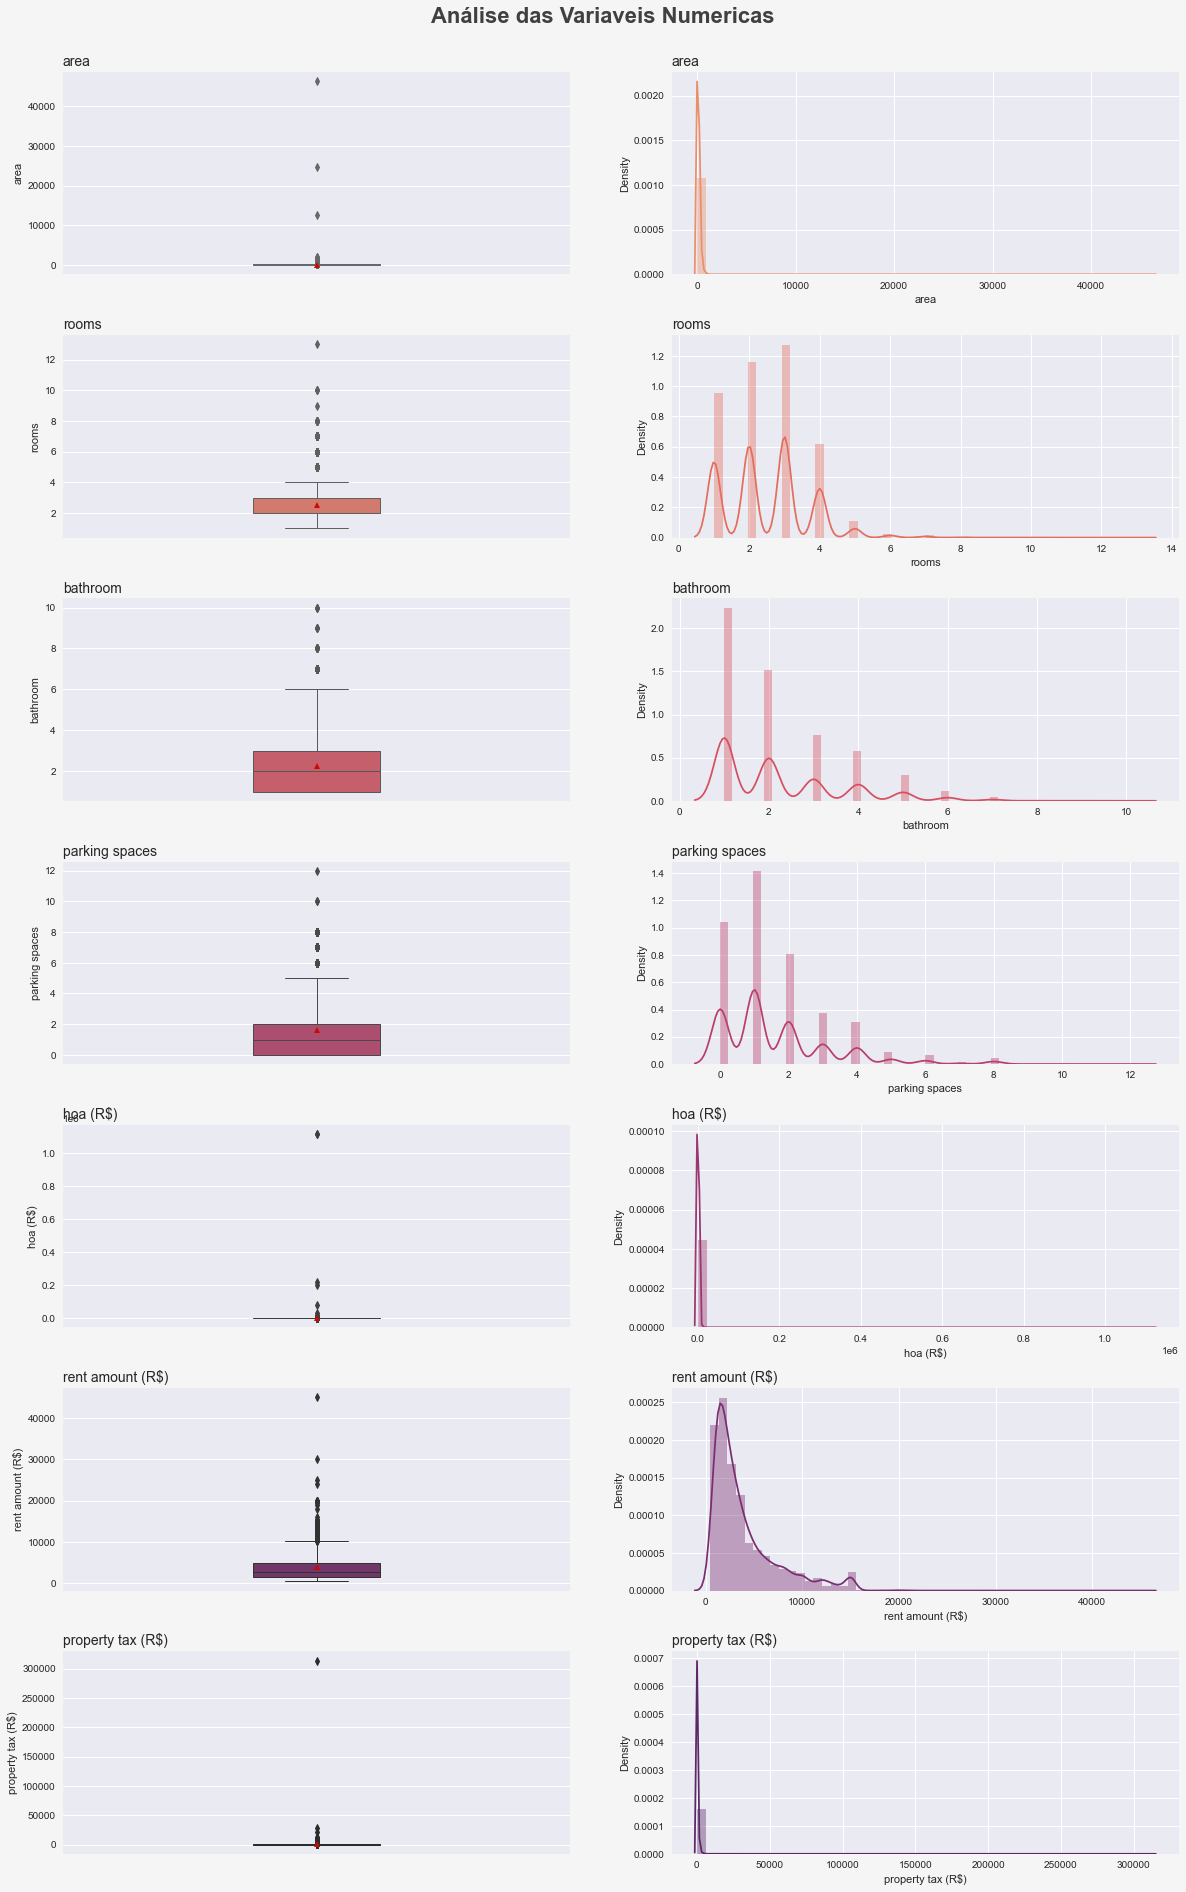

In [24]:
# Grid - Gráficos

# Tamanho
Figura, Eixo = plt.subplots( figsize=(20, 30) )
# Cor de fundo
cor_fundo = '#f5f5f5'
Figura.set_facecolor( cor_fundo )
# Paleta de Cores
paleta_cores = sns.color_palette( 'flare', len(colunas_numericas) * 2 )
# Titulo
plt.suptitle('Análise das Variaveis Numericas', fontsize=22, color='#404040', fontweight=600 )

# Estrutura
linhas = 7 # (Todas as infos numericas)
colunas = 2 #( Boxplot - Distplot)
posicao = 1 # Posicao inicial do grid

# Loop para plotar os gráficos
for coluna in colunas_numericas:

  # Plot no Grid -- Boxplot
  plt.subplot( linhas, colunas, posicao )
  # Titulo
  plt.title( f'{coluna}', loc='left', fontsize=14, fontweight=200 )
  # Plot
  sns.boxplot( data=base_dados, y=coluna, showmeans=True, saturation=0.75, linewidth=1, color=paleta_cores[posicao], width=0.25 )
  # Mudar
  posicao += 1

  # Plot no Grid -- Distplot
  plt.subplot( linhas, colunas, posicao )
  # Titulo
  plt.title( f'{coluna}', loc='left', fontsize=14, fontweight=200 )
  # Plot
  sns.distplot( base_dados[coluna], color=paleta_cores[ posicao - 1 ] )
  # Mudar
  posicao += 1

# Ajute de Grid
plt.subplots_adjust( top=0.95, hspace=0.3 )

##### ANALISANDO CADA COLUNA NUMÉRICA
*Obs: Os valores errados podem acabar distorcendo toda a base*

In [25]:
# Analisando a 'área' dos imóveis, seus  outliers, etc..
base_dados.loc[ base_dados['area'] <= 10000]['area'].describe()

count    10689.000000
mean       141.431846
std        134.348219
min         11.000000
25%         56.000000
50%         90.000000
75%        182.000000
max       2000.000000
Name: area, dtype: float64

In [26]:
# Analisando os valores de condomínio, seus outliers, etc..
base_dados.loc[ base_dados['hoa (R$)'] <= 10000]['hoa (R$)'].describe()

count    10683.000000
mean       911.949827
std       1104.885520
min          0.000000
25%        170.000000
50%        558.000000
75%       1230.000000
max      10000.000000
Name: hoa (R$), dtype: float64

In [27]:
# Organizando os valores de condomínio do maior para o menor
# Obs: os 4 primeiros valores provavelmente estão errados, não existe condomínio mais caro que o valor do aluguel
base_dados['hoa (R$)'].sort_values(ascending=False).head(20)

255      1117000
6979     1117000
6230      220000
2859      200000
2928       81150
1444       32000
1213       15000
415        14130
5293       14000
8858       10000
974        10000
547         9900
7020        9500
7679        9000
1862        8600
6185        8500
1072        8500
10184       8362
254         8300
722         8133
Name: hoa (R$), dtype: int64

In [28]:
# analisando o 1º imóvel acima com índice 255 em que o valor do Condomínio está 1 milhão
base_dados.iloc[ 255 ]

city                 Belo Horizonte
area                            155
rooms                             1
bathroom                          4
parking spaces                    0
floor                             4
animal                    not acept
furniture             not furnished
hoa (R$)                    1117000
rent amount (R$)               2790
property tax (R$)                64
Name: 255, dtype: object

In [29]:
# analisando o 5º imóvel acima com índice 1213, esse já faz sentido uma área de 850m² ter um condomínio no valor de 15mil 
base_dados.iloc[ 1213 ]

city                     São Paulo
area                           850
rooms                            6
bathroom                         7
parking spaces                   4
floor                            0
animal                   not acept
furniture            not furnished
hoa (R$)                     15000
rent amount (R$)             13000
property tax (R$)             2465
Name: 1213, dtype: object

In [30]:
# Analisando os valores de aluguéis (valor máximo de aluguel mensal R$ 45 mil)
base_dados['rent amount (R$)'].describe()

count    10692.000000
mean      3896.247194
std       3408.545518
min        450.000000
25%       1530.000000
50%       2661.000000
75%       5000.000000
max      45000.000000
Name: rent amount (R$), dtype: float64

In [31]:
# Ordedando do maior valor para o menor
base_dados['rent amount (R$)'].sort_values(ascending=False).head(10)

2182    45000
7748    30000
6947    25000
2619    24000
1743    20000
2859    20000
1253    20000
5525    20000
157     20000
6185    19500
Name: rent amount (R$), dtype: int64

In [32]:
# Analisando o maior valor de aluguel
# Realmente é um imóvel grande com um IPTU mensal de R$ 8750
base_dados.iloc[ 2182 ]

city                     São Paulo
area                           700
rooms                            4
bathroom                         7
parking spaces                   8
floor                            0
animal                       acept
furniture            not furnished
hoa (R$)                         0
rent amount (R$)             45000
property tax (R$)             8750
Name: 2182, dtype: object

In [33]:
# Analisando os valores de IPTU (valor máximo de IPTU mensal R$ 313 mil)
base_dados['property tax (R$)'].describe()

count     10692.000000
mean        366.704358
std        3107.832321
min           0.000000
25%          38.000000
50%         125.000000
75%         375.000000
max      313700.000000
Name: property tax (R$), dtype: float64

In [34]:
# Ordenando os valores de IPTU do maior para o menor
base_dados['property tax (R$)'].sort_values(ascending=False)

6645     313700
6243      28120
1699      21880
10172     12500
5331      10830
          ...  
7790          0
2179          0
7794          0
2173          0
7661          0
Name: property tax (R$), Length: 10692, dtype: int64

In [35]:
# Analisando o 1º imóvel acima com IPTU no valor de R$ 313 mil
# Um aluguel de R$ 2500,00 mensal nunca teria um IPTU nesse valor
base_dados.iloc[ 6645 ]

city                     São Paulo
area                            42
rooms                            1
bathroom                         2
parking spaces                   1
floor                            6
animal                   not acept
furniture            not furnished
hoa (R$)                       690
rent amount (R$)              2500
property tax (R$)           313700
Name: 6645, dtype: object

## **Engenharia de Features**
*Analisando as variáveis que serão necessárias para o modelo*

##### *Ajustando algumas colunas categóricas*

In [36]:
# 'Cidade' vamos retirar da base (Vamos utilizar apenas a cidade de São Paulo) e o andar já convertemos para inteiro
colunas_categoricas

Index(['city', 'floor', 'animal', 'furniture'], dtype='object')

In [37]:
# A coluna 'animal' só tem 2 informações, aceita ou não animais
base_dados['animal'].head()

0        acept
1        acept
2        acept
3        acept
4    not acept
Name: animal, dtype: object

In [38]:
base_dados['furniture'].head()

0        furnished
1    not furnished
2    not furnished
3    not furnished
4    not furnished
Name: furniture, dtype: object

In [39]:
# Vamos converter a coluna 'animal' para 0 e 1 (1 aceita / 0 não aceita)
base_dados['animal'] = base_dados['animal'].map( { 'acept':1, 'not acept':0 } )

In [40]:
# Mobilia também vamos converter ( 1=mobiliado / 0=não mobiliado)
base_dados['furniture'] = base_dados['furniture'].map( { 'furnished':1, 'not furnished':0 } )

In [41]:
base_dados[['animal', 'furniture']].head()

,animal,furniture
0,1,1
1,1,0
2,1,0
3,1,0
4,0,0


In [42]:
# Filtrar a cidade de 'São Paulo'ArithmeticError
filtro_sp = base_dados.loc[ base_dados['city'] == 'São Paulo' ]
# Verificar
filtro_sp.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$)
0,São Paulo,70,2,1,1,7,1,1,2065,3300,211
1,São Paulo,320,4,4,0,20,1,0,1200,4960,1750
4,São Paulo,25,1,1,0,1,0,0,0,800,25
5,São Paulo,376,3,3,7,0,1,0,0,8000,834
7,São Paulo,213,4,4,4,4,1,0,2254,3223,1735


In [43]:
# Retirando a coluna cidade (já filtramos apenas São Paulo, então não vamos precisar dessa coluna para treinar o modelo)
filtro_sp.drop( columns='city', inplace=True )

##### *Separação dos dados*

In [44]:
# 'Caracteristicas' do imóvel que serão usadas para prever o valor do aluguel
# 'Previsor' é o alvo, a partir das características do imóvel, queremos saber o valor do aluguel
caracteristicas = filtro_sp.drop( columns=['rent amount (R$)'] )
previsor = filtro_sp['rent amount (R$)']

# Verificar
caracteristicas.shape, previsor.shape

((5887, 9), (5887,))

In [45]:
caracteristicas.head()

,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),property tax (R$)
0,70,2,1,1,7,1,1,2065,211
1,320,4,4,0,20,1,0,1200,1750
4,25,1,1,0,1,0,0,0,25
5,376,3,3,7,0,1,0,0,834
7,213,4,4,4,4,1,0,2254,1735


In [46]:
previsor.head()

0    3300
1    4960
4     800
5    8000
7    3223
Name: rent amount (R$), dtype: int64

##### *Analisar correlação das Características e Previsor*

In [47]:
'''
    Próxima de 1  = Correlação Positiva (ambas sobem)
    Próxima de -1 = Correlação Negativa (uma sobe e outra desce)

    Ex: Salário x Tempo de empresa - Correlação Positiva, quando mais tempo de casa, maior é o salário
          Dólar x Real             - Correlação Negativa, quando o dólar sobe, o real fica desvalorizado
'''

'\n    Próxima de 1  = Correlação Positiva (ambas sobem)\n    Próxima de -1 = Correlação Negativa (uma sobe e outra desce)\n\n    Ex: Salário x Tempo de empresa - Correlação Positiva, quando mais tempo de casa, maior é o salário\n          Dólar x Real             - Correlação Negativa, quando o dólar sobe, o real fica desvalorizado\n'

In [48]:
# Correlação entre as variáveis
filtro_sp.corr()

,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$)
area,1.000000,0.306863,0.316543,0.300795,-0.038790,0.073565,-0.018145,0.056091,0.274749,0.065289
rooms,0.306863,1.000000,0.759432,0.645041,-0.092117,0.213963,-0.088931,0.136343,0.537622,0.071702
bathroom,0.316543,0.759432,1.000000,0.703530,-0.015503,0.159097,0.005864,0.163205,0.638924,0.101616
parking spaces,0.300795,0.645041,0.703530,1.000000,-0.038378,0.165253,-0.015155,0.115951,0.573373,0.092362
floor,-0.038790,-0.092117,-0.015503,-0.038378,1.000000,-0.014202,0.135180,0.107211,0.065294,0.005672
animal,0.073565,0.213963,0.159097,0.165253,-0.014202,1.000000,-0.066208,0.020575,0.107147,-0.005308
furniture,-0.018145,-0.088931,0.005864,-0.015155,0.135180,-0.066208,1.000000,0.042860,0.154316,-0.007852
hoa (R$),0.056091,0.136343,0.163205,0.115951,0.107211,0.020575,0.042860,1.000000,0.188147,0.028872
rent amount (R$),0.274749,0.537622,0.638924,0.573373,0.065294,0.107147,0.154316,0.188147,1.000000,0.091749
property tax (R$),0.065289,0.071702,0.101616,0.092362,0.005672,-0.005308,-0.007852,0.028872,0.091749,1.000000


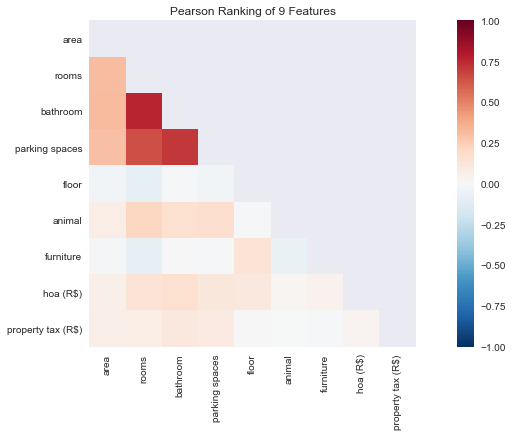

In [49]:
# Correlação com 'Yellowbrick'
from yellowbrick.features import Rank2D

# Definir o método (correlação de 'pearson' é a mais tradicional)
Correlacao = Rank2D( algoritmo='pearson')

# Fitar função
Correlacao.fit( caracteristicas, previsor )
Correlacao.transform( caracteristicas )
Correlacao.show();

## **Separação dos dados de Treino e Teste**

In [50]:
# X = caractetisticas do imóvel, sao as features necessárias para chegar no valor do imóvel
# y = alvo, é o valor do imóvel que queremos descobrir

X_treino, X_teste, y_treino, y_teste = train_test_split( caracteristicas, previsor, test_size=0.2, random_state=10)

print(f'Dados de treino: {X_treino.shape[0]}')
print(f'Dados de teste: {X_teste.shape[0]}')

Dados de treino: 4709
Dados de teste: 1178


In [51]:
# Função para analisar as features mais relevantes (normalmente se alguma feature tem o peso '0', retiramos do modelo)
# "mutual_info_regression" avalia se existe dependência entre 2 variáveis (quanto maior o valor, maior a dependência)
# "SelectKBest" seleciona as melhores features, no caso vamos selecionar todas

def Selecao_Features( X_treino, y_treino):

    # Configurar para selecionar as features
    selecao = SelectKBest( score_func=mutual_info_regression, k='all')

    # Fitar o aprendizado
    selecao.fit( X_treino, y_treino )

    return selecao

In [52]:
# Aplicando a função (passando os dados de treino, a função vai fazer uma análise de relação mútua entre as features e vai retornar as melhores)
scores = Selecao_Features( X_treino, y_treino)

# Analisar trazendo cada feature e o quanto ela tem relação com o alvo
for posicao, score in enumerate(scores.scores_):
    print(f'{X_treino.columns[posicao]}: {score}')

area: 0.05392974844831189
rooms: 0.24864241172780677
bathroom: 0.3213158447396989
parking spaces: 0.2337761033984065
floor: 0.022096655685356126
animal: 0.029156236726232354
furniture: 0.029703154800751808
hoa (R$): 0.053295068780501165
property tax (R$): 0.17105415958415549


## **Construção do Modelo**

In [53]:
# Instanciar o Modelo - Usando o parâmetro max_deph=5 para evitar overfithing (profundidade da árvore)
Modelo_Floresta = RandomForestRegressor( max_depth=5)

In [54]:
# Fitar/Treinar o modelo com os dados de treino
Modelo_Floresta.fit( X_treino, y_treino)

RandomForestRegressor(max_depth=5)

## **Avaliar a performance do modelo com suas métricas**

In [55]:
# Chamar o modelo já treinado para fazer as previsões em cima dos dados de teste (sem o y_test que é a resposta)
previsoes = Modelo_Floresta.predict( X_teste)

In [56]:
previsoes[0:5]

array([1541.45390439, 8670.25226732, 7889.41906392, 5005.65157009,
       3541.35009653])

In [57]:
# Comparar os valores reais com as previsões e saber qual a taxa de erro do modelo 
# (nesse caso ele está errando em média R$ 2459,00)

print(f'RMSE: { round(sqrt(mean_squared_error( y_teste, previsoes )), 2) }')
print(f'Score: { r2_score( y_teste, previsoes ) } ')

RMSE: 2467.72
Score: 0.5592606392500787 


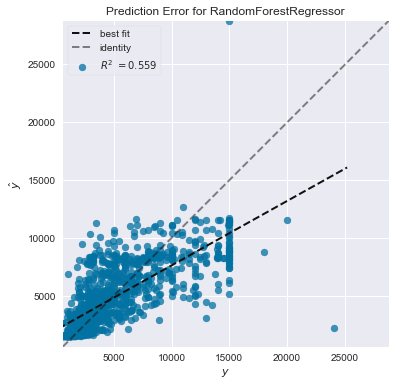

In [58]:
# Avaliando com Yellowbrick

Modelo = RandomForestRegressor( max_depth=5 )
Erro_Modelo = PredictionError( Modelo )

# Fitar
Erro_Modelo.fit( X_treino, y_treino )
Erro_Modelo.score( X_teste, y_teste )
Erro_Modelo.show();

## **Exportar o modelo treinado**

In [59]:
# 1º parâmetro é o modelo treinado e o 2º é o nome do arquivo que vamos salvar 
joblib.dump( Modelo_Floresta, 'Modelo_RandomForest_v1.pkl')

['Modelo_RandomForest_v1.pkl']

In [60]:
# Importando o arquivo
modelo = joblib.load('Modelo_RandomForest_v1.pkl')

In [63]:
modelo

RandomForestRegressor(max_depth=5)

In [97]:
# Testando o arquivo carregado com o modelo (testando na primeira linha X_test)
linha = 3
print( X_teste.iloc[linha].values )
print( round(float(modelo.predict( [X_teste.iloc[linha].values] )), 2) )

[100   2   4   2  12   0   1 885 330]
5005.65
